In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the data
x_train_full = x_train_full.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# Reshape the data
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)


2024-04-07 11:38:18.852236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 11:38:18.852299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 11:38:18.854197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In the above cell I loaded the CIFAR-10 dataset and then normalized it and reshaped it. In the cell below I one hot encoded all the labels

In [2]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode the class labels
num_classes = 10  # Number of classes in CIFAR-10
one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

The below cell show the architecture of CVAE

In [16]:
class CVAELayer(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(CVAELayer, self).__init__()
        self.latent_dim = latent_dim

    def build(self, input_shape):
        self.z_mean = self.add_weight(shape=(self.latent_dim,), initializer='zeros', trainable=True, name='z_mean')
        self.z_log_var = self.add_weight(shape=(self.latent_dim,), initializer='zeros', trainable=True, name='z_log_var')

    def call(self, inputs):
        recon_img, img = inputs
        reconstruction_loss = mse(K.flatten(img), K.flatten(recon_img))
        kl_loss = -0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(vae_loss)
        return recon_img

def build_cvae(latent_dim, num_classes):
    # Encoder
    input_img = Input(shape=(32, 32, 3))
    input_label = Input(shape=(num_classes,))
    
    x = Conv2D(64, (3, 3), strides=2, padding="same")(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    
    # Concatenate conditional information with the flattened features
    x = Concatenate()([x, input_label])
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Decoder
    x = Concatenate()([z, input_label])
    x = Dense(8*8*128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 128))(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    output_img = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    # Define the model
    cvae_out = CVAELayer(latent_dim)([output_img, input_img])
    cvae = Model([input_img, input_label], cvae_out)
    cvae.compile(optimizer="adam")

    return cvae

# Example usage:
latent_dim = 100
num_classes = 10  # Number of classes in CIFAR-10
cvae = build_cvae(latent_dim, num_classes)
cvae.summary()  # Print model summary for debugging

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ leaky_re_lu_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8192)      │          0 │ leaky_re_lu_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 8202)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │  4,199,936 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │     51,300 │ leaky_re_lu_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 100)       │     51,300 │ leaky_re_lu_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 110)       │          0 │ z[0][0],          │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8192)      │    909,312 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8192)      │     32,768 │ dense_5[0][0]   

 Total params: 5,547,155 (21.16 MB)

 Trainable params: 5,528,979 (21.09 MB)

 Non-trainable params: 18,176 (71.00 KB)

In the cell below I am training the model 

In [17]:
# Train the model with one-hot encoded class labels
cvae.compile(optimizer="adam", loss="mse")

cvae.fit([x_train, y_train_one_hot], x_train, epochs=15, batch_size=64, validation_data=([x_val, y_val_one_hot], x_val), verbose=1)

Epoch 1/15
 11/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1568

W0000 00:00:1712490954.593347    2025 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712490954.596881    2025 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0727

W0000 00:00:1712490963.537710    2026 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0725 - val_loss: 0.1280
Epoch 2/15
 11/625 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0211

W0000 00:00:1712490964.928463    2027 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0200 - val_loss: 0.1278
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0162 - val_loss: 0.1213
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0149 - val_loss: 0.0454
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 12/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 13/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/st

Here I am predicting images from the test data

 54/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1712491131.486020    2026 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


W0000 00:00:1712491133.081818    2025 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


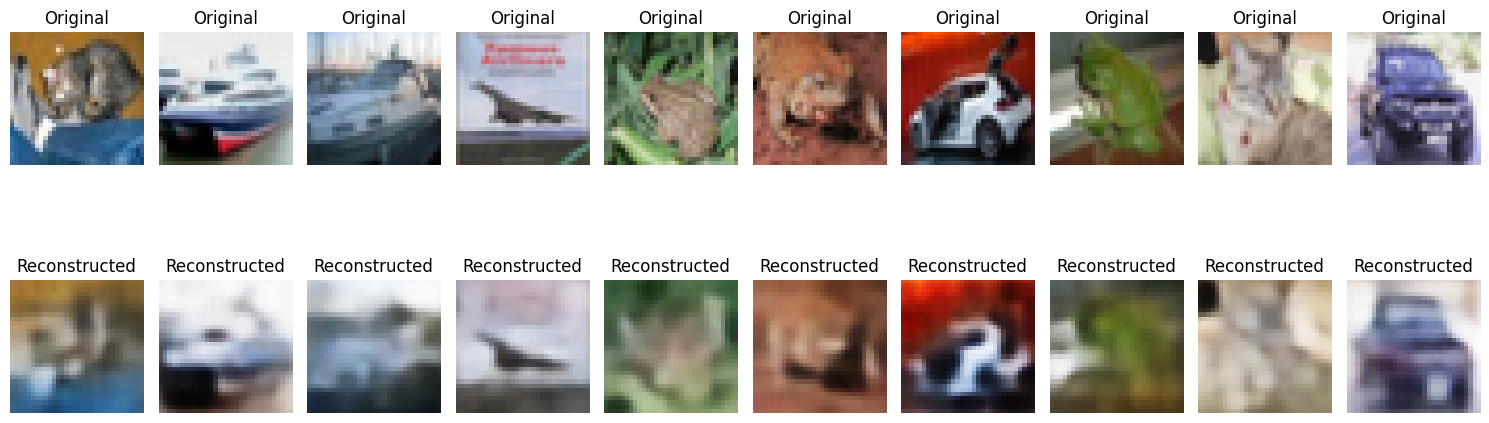

In [20]:
# Visualize original and reconstructed images for comparison
reconstructed_images = cvae.predict([x_test, y_test_one_hot])

num_samples = 10  # Number of samples to visualize
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    # Original image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()
